In [3]:
import logging 
import feather
import sys
import datetime
import time
import os
from pathlib import Path
import gc
from collections import Counter
import codecs

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Load data

In [6]:
%%time

data_DIR = Path('/Users/xszpo/Google Drive/DataScience/Projects/201908_credit/'
                '01_data')

df_train = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_train.feather'))

df_test = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_test.feather'))


CPU times: user 1.27 s, sys: 1.54 s, total: 2.81 s
Wall time: 3.02 s


In [2]:
#df_train=df_train.assign(default = lambda x: x['default'].apply(int))
#df_train=df_train.drop(['last_credit_pull_d'],axis=1)

# Features overview

In [5]:
df_train.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
term,714794,2,36 months,501467
grade,714794,7,B,206259
sub_grade,714794,35,B3,45323
emp_title,672558,242341,Teacher,11334
emp_length,677193,11,10+ years,236362
home_ownership,714794,6,MORTGAGE,357394
loan_status,714794,9,Fully Paid,524311
desc,88104,87230,,167
purpose,714794,14,debt_consolidation,420834
title,707275,46407,Debt consolidation,339315


In [6]:
df_train.select_dtypes(exclude=['object']).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,714794.0,14874.929560,8497.093462,500.000000,8000.000000,13100.000000,20000.000000,40000.00
funded_amnt,714794.0,14863.161449,8492.581108,500.000000,8000.000000,13025.000000,20000.000000,40000.00
int_rate,714794.0,13.144873,4.451363,5.320000,9.750000,12.990000,15.960000,28.99
installment,714794.0,440.034762,246.636446,14.010000,261.570000,385.120000,578.110000,1503.85
annual_inc,714790.0,75747.027811,65517.944948,0.000000,46000.000000,65000.000000,90000.000000,9550000.00
dti,714780.0,18.310427,8.686971,-1.000000,12.000000,17.780000,24.150000,999.00
delinq_2yrs,714775.0,0.318293,0.867652,0.000000,0.000000,0.000000,0.000000,39.00
inq_last_6mths,714774.0,0.679261,0.983809,0.000000,0.000000,0.000000,1.000000,32.00
mths_since_last_delinq,351824.0,34.011693,21.897075,0.000000,15.000000,31.000000,50.000000,192.00
mths_since_last_record,112542.0,69.529482,27.634142,0.000000,51.000000,70.000000,90.000000,121.00


# Numeric

## Null percentage

In [7]:
percent_missing = df_train.select_dtypes(exclude=['object']).isnull().sum() * 100 / len(df_train.select_dtypes(exclude=['object']))
missing_value_df = pd.DataFrame({'column_name': df_train.select_dtypes(exclude=['object']).columns,
                                 'percent_missing': percent_missing})


In [8]:
missing_value_df.query("percent_missing>70").sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
dti_joint,dti_joint,99.687602
annual_inc_joint,annual_inc_joint,99.687043
il_util,il_util,86.809207
mths_since_rcnt_il,mths_since_rcnt_il,85.197693
all_util,all_util,84.784847
inq_last_12m,inq_last_12m,84.784427
open_acc_6m,open_acc_6m,84.784427
total_cu_tl,total_cu_tl,84.784427
open_rv_24m,open_rv_24m,84.784288
inq_fi,inq_fi,84.784288


It could mean something - wait till later to delete

## Check collinearity

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/

In [9]:
# Create correlation matrix
corr_matrix = df_train.select_dtypes(exclude=['object']).corr(method='pearson')
# mean correlation between features
mean_corr = corr_matrix.drop(['default'], axis=1).abs().mean().sort_values(ascending=False)

In [10]:
# Select upper and lower triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

# Find index of feature columns with correlation greater than x
cor_lim = 0.85
to_drop_u = [column for column in upper.columns if any(upper[column] > cor_lim)]
to_drop_l = [column for column in lower.columns if any(lower[column] > cor_lim)]
high_corr = list(set(to_drop_u+to_drop_l))

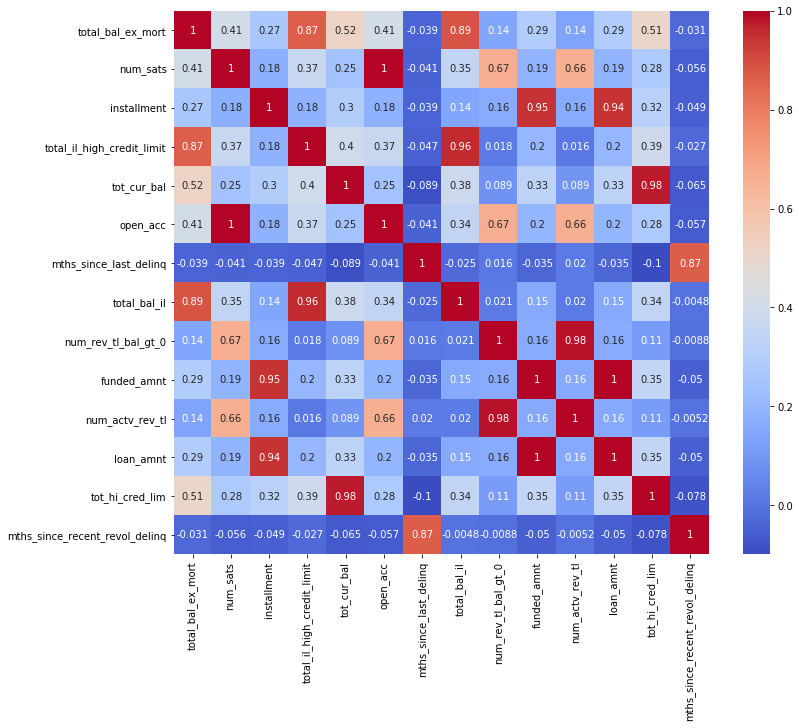

In [11]:
# display high correlated variables
corr_matrix_hc = df_train[high_corr].corr(method='pearson')

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_hc, ax=ax,cbar=True,cmap='coolwarm', annot=True)

In [12]:
columns = corr_matrix_hc.columns

done = []
to_drop = []
for sel_col in columns:
    if sel_col not in done:
        x = corr_matrix_hc.loc[sel_col].replace(1,0)
        second_val = np.argmax(np.array(x), axis=None)
        cor_o_t = max(x)
        feature_one = sel_col
        feature_two = x.index[second_val]
        feature_one_mc = mean_corr.loc[feature_one]
        feature_two_mc = mean_corr.loc[feature_two]
        feature_one_nr = missing_value_df.loc[feature_one].percent_missing
        feature_two_nr = missing_value_df.loc[feature_two].percent_missing
        
        drop = feature_one if mean_corr.loc[feature_one]>mean_corr.loc[feature_two] else feature_two
        print("Corr btw {one} (mc: {feature_one_mc}, nr:{feature_one_nr}) and {two} (mc: {feature_two_mc}, nr:{feature_two_nr}) is {cor}, \n--- drop: {drop} ---\n".format(
            **{'cor':np.round(cor_o_t,2), 'one':feature_one, 'two':feature_two,
               'feature_one_mc':np.round(feature_one_mc,3), 'feature_two_mc':np.round(feature_two_mc,3),
               'drop':drop,'feature_one_nr': np.round(feature_one_nr,3),'feature_two_nr':np.round(feature_two_nr,3)}))
        done.append(feature_one)
        done.append(feature_two)
        
        to_drop.append(drop)

    

Corr btw total_bal_ex_mort (mc: 0.193, nr:4.895) and total_bal_il (mc: 0.153, nr:84.784) is 0.89, 
--- drop: total_bal_ex_mort ---

Corr btw num_sats (mc: 0.236, nr:5.726) and open_acc (mc: 0.236, nr:0.003) is 1.0, 
--- drop: open_acc ---

Corr btw installment (mc: 0.138, nr:0.0) and funded_amnt (mc: 0.148, nr:0.0) is 0.95, 
--- drop: funded_amnt ---

Corr btw total_il_high_credit_limit (mc: 0.159, nr:6.863) and total_bal_il (mc: 0.153, nr:84.784) is 0.96, 
--- drop: total_il_high_credit_limit ---

Corr btw tot_cur_bal (mc: 0.168, nr:6.863) and tot_hi_cred_lim (mc: 0.175, nr:6.863) is 0.98, 
--- drop: tot_hi_cred_lim ---

Corr btw mths_since_last_delinq (mc: 0.088, nr:50.78) and mths_since_recent_revol_delinq (mc: 0.087, nr:66.834) is 0.87, 
--- drop: mths_since_last_delinq ---

Corr btw num_rev_tl_bal_gt_0 (mc: 0.18, nr:6.863) and num_actv_rev_tl (mc: 0.181, nr:6.863) is 0.98, 
--- drop: num_actv_rev_tl ---

Corr btw loan_amnt (mc: 0.148, nr:0.0) and funded_amnt (mc: 0.148, nr:0.0) is

Drop:
* Corr btw total_bal_ex_mort (mc: 0.193, nr:4.895) and 'total_bal_il' (mc: 0.153, nr:84.784) is 0.89,
**drop total_bal_il**, because of null percentage 85%,
* Corr btw mths_since_recent_revol_delinq (mc: 0.086, nr:66.834) and mths_since_last_delinq (mc: 0.087, nr:50.78) is 0.87, **drop mths_since_recent_revol_delinq**, because of null percentage 66%,
* 'num_actv_rev_tl',
* 'open_acc',
* 'funded_amnt',
* 'tot_hi_cred_lim',
* 'total_il_high_credit_limit',


In [13]:
to_drop = ['total_bal_il','mths_since_recent_revol_delinq',
 'num_actv_rev_tl', 'open_acc', 'funded_amnt', 'tot_hi_cred_lim', 'total_il_high_credit_limit']

**DROP FEATURES**

In [14]:
df_train = df_train.drop(to_drop, axis=1)

# text features


In [15]:
text_features = ['emp_title','desc','title']

In [16]:
df_train['emp_title'].sample(10,random_state=666)

577028                         IT Lead
469807                            None
561585                District manager
559313    Psychiatric Social Worker II
160999                       Custodian
298538                           Sales
83699                  Room attendant 
413101                Material Handler
633444                      Sr Analyst
643533            WARE HOUSE /SHIPPING
Name: emp_title, dtype: object

In [17]:
print('desc')
df_train[['desc']].dropna().sample(10,random_state=666).values

desc


array([['  Borrower added on 05/23/13 > I accumulated debt, helpin my child through university &amp; also after graduation. I would like to have one low payment to erase this debt, at a lower rate than each has individually, if paid separately.<br>'],
       ['  Borrower added on 02/11/13 > Hi I would like to be free of dept in short terms .<br><br> Borrower added on 02/11/13 > I would love to get out of dept in a short terms<br>'],
       [' I will use the money to take my Girlfriend,on a dream vacation to celebrate our 10th anniversary together. I am a very hard working responsible person.'],
       ['  Borrower added on 10/17/12 > I am seeking this loan in an effort to consolidate all of my debt (and pay it off in a finite period), which I incurred due to a (positive, but expensive) life event.  Thank you.<br>'],
       ['  Borrower added on 09/03/12 > Paying off high interest credit cards I acquired to start investing in a college fund for my daughter<br>'],
       ['  Borrower add

In [18]:
print('title')
df_train['title'].sample(10,random_state=666)

title


577028                        Debt consolidation
469807    Payoff high interests rate credit card
561585                   Credit card refinancing
559313                        Debt consolidation
160999                        Debt consolidation
298538                        Debt consolidation
83699                    Credit card refinancing
413101                               consolidate
633444                             Car financing
643533                          Home improvement
Name: title, dtype: object

# train development split

In [19]:
_tmp = Counter(df_train.default)
for i in _tmp:
    print("Default - %s = %i, %.0f%%"% (i, _tmp[i], (_tmp[i]/df_train.shape[0])*100))

Default - 0 = 590239, 83%
Default - 1 = 124555, 17%


In [20]:
df_train.shape

(714794, 86)

In [21]:
df_train_sample = df_train.sample(100000, random_state=666)

In [22]:
_tmp = Counter(df_train_sample.default)
for i in _tmp:
    print("Default - %s = %i, %.0f%%"% (i, _tmp[i], (_tmp[i]/df_train_sample.shape[0])*100))

Default - 0 = 82610, 83%
Default - 1 = 17390, 17%


# Build basic model

##### repair text

In [23]:
df_train_sample.fillna(value = {'desc': {'': np.nan},'emp_title': {'': np.nan},'title': {'': np.nan}}, inplace=True)

In [24]:
df_train_sample.fillna(value = {'desc': 'novalue', 'emp_title': 'novalue', 'title': 'novalue'}, inplace=True)

##### group features

In [25]:
features_exclude_gc = ['random_value','grade','loan_status']
features_exclude_too_strong = [] #['int_rate']
exclude = features_exclude_gc+features_exclude_too_strong

features_text = ['emp_title','desc','title']
features_numeric = [i for i in df_train_sample.select_dtypes(exclude=['object','datetime64[ns]']).columns if i not in exclude]
features_cat = [i for i in df_train_sample.select_dtypes(include=['object']).columns if i not in exclude]
features_datatime = [i for i in df_train_sample.select_dtypes(include=['datetime64[ns]']).columns if i not in exclude]


##### text dimensionality reduction using truncated SVD (aka LSA) or LDA

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [27]:

seed = 666
max_features_Vectorizer = 1000
n_components=3


pipe_text = make_union(
    make_pipeline(
        ColumnTransformer([
        (features_text[0], 
         TfidfVectorizer(
             lowercase=True,
             ngram_range=(1, 3),
             max_features=max_features_Vectorizer,
             dtype=np.float32,
             use_idf=True),
         features_text[0])
        ])
        ,TruncatedSVD(n_components=n_components,random_state=666,n_iter=10)
    ),
    make_pipeline(
        ColumnTransformer([
        (features_text[1], 
         TfidfVectorizer(
             lowercase=True,
             ngram_range=(1, 3),
             max_features=max_features_Vectorizer,
             dtype=np.float32,
             use_idf=True),
         features_text[1])
        ])
        ,TruncatedSVD(n_components=n_components,random_state=666,n_iter=10)
    ),
    make_pipeline(
        ColumnTransformer([
        (features_text[2], 
         TfidfVectorizer(
             lowercase=True,
             ngram_range=(1, 3),
             max_features=max_features_Vectorizer,
             dtype=np.float32,
             use_idf=True),
         features_text[2])
        ])
        ,TruncatedSVD(n_components=n_components,random_state=666,n_iter=10)
    ),
    )

In [28]:
import itertools

list2d = [["text__"+x+"__comp_"+str(z) for z,x in enumerate([i]*n_components)] for i in features_text]
colnames_text_svd = list(itertools.chain(*list2d))
colnames_text_svd

['text__emp_title__comp_0',
 'text__emp_title__comp_1',
 'text__emp_title__comp_2',
 'text__desc__comp_0',
 'text__desc__comp_1',
 'text__desc__comp_2',
 'text__title__comp_0',
 'text__title__comp_1',
 'text__title__comp_2']

In [29]:
%%time
df_text_svd = pd.DataFrame(pipe_text.fit_transform(df_train_sample), columns=colnames_text_svd)

CPU times: user 7.3 s, sys: 360 ms, total: 7.66 s
Wall time: 7.03 s


##### concat dataset

In [30]:
df_train_sample_notext = df_train_sample.drop(['loan_status']+text_features+exclude, axis=1).reset_index(drop=True)


In [31]:
df_text_svd = df_text_svd.reset_index(drop=True)


In [32]:
df_train_sample_svd = pd.concat([df_train_sample_notext,df_text_svd], axis=1)


In [33]:
for col in df_train_sample_svd.select_dtypes(include=['object']).columns:
    df_train_sample_svd[col] = df_train_sample_svd[col].replace([' '],['nocat']).fillna('nocat').astype('category')


In [34]:
rdate1 = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d").date()

for col in features_datatime:
    df_train_sample_svd[col] = df_train_sample_svd[col].apply(lambda x: (x.date() - rdate1).days)


In [35]:
train_X, dev_X, train_y, dev_y = train_test_split(
    df_train_sample_svd.drop(['default'], axis=1), 
    df_train_sample_svd['default'].tolist(), random_state=666)


### Create model lightgbm

In [36]:
import lightgbm as lgb


In [37]:
train_X.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'purpose',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_

In [38]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_X, train_y)
lgb_test = lgb.Dataset(dev_X, dev_y, reference=lgb_train)

In [39]:
params = {
    'learning_rate': 0.03, 
    'max_depth': 5,
    'lambda_l1': 16.7, 
    'min_data_in_leaf':100, 
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc', 
    'feature_fraction': .8, 
    'is_training_metric': False, 
    'seed': 666
}

In [40]:
%%time
evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=20)

/Users/xszpo/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	training's auc: 0.705495	valid_1's auc: 0.687379
[40]	training's auc: 0.716897	valid_1's auc: 0.690472
[60]	training's auc: 0.724425	valid_1's auc: 0.690792
[80]	training's auc: 0.731887	valid_1's auc: 0.692578
[100]	training's auc: 0.740178	valid_1's auc: 0.694577
CPU times: user 8.17 s, sys: 701 ms, total: 8.88 s
Wall time: 5.37 s


Plotting metrics recorded during training...


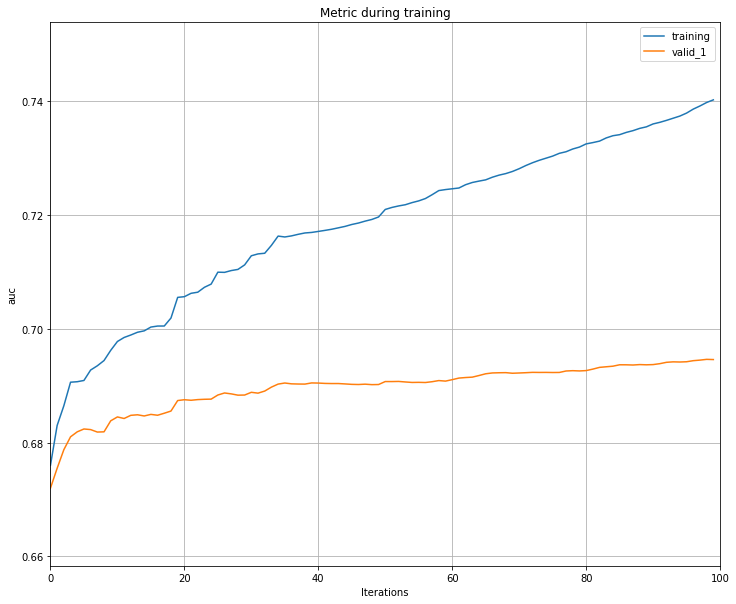

In [41]:
print('Plotting metrics recorded during training...')
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_metric(evals_result, metric='auc',ax=ax)
plt.show()

Plotting feature importances...


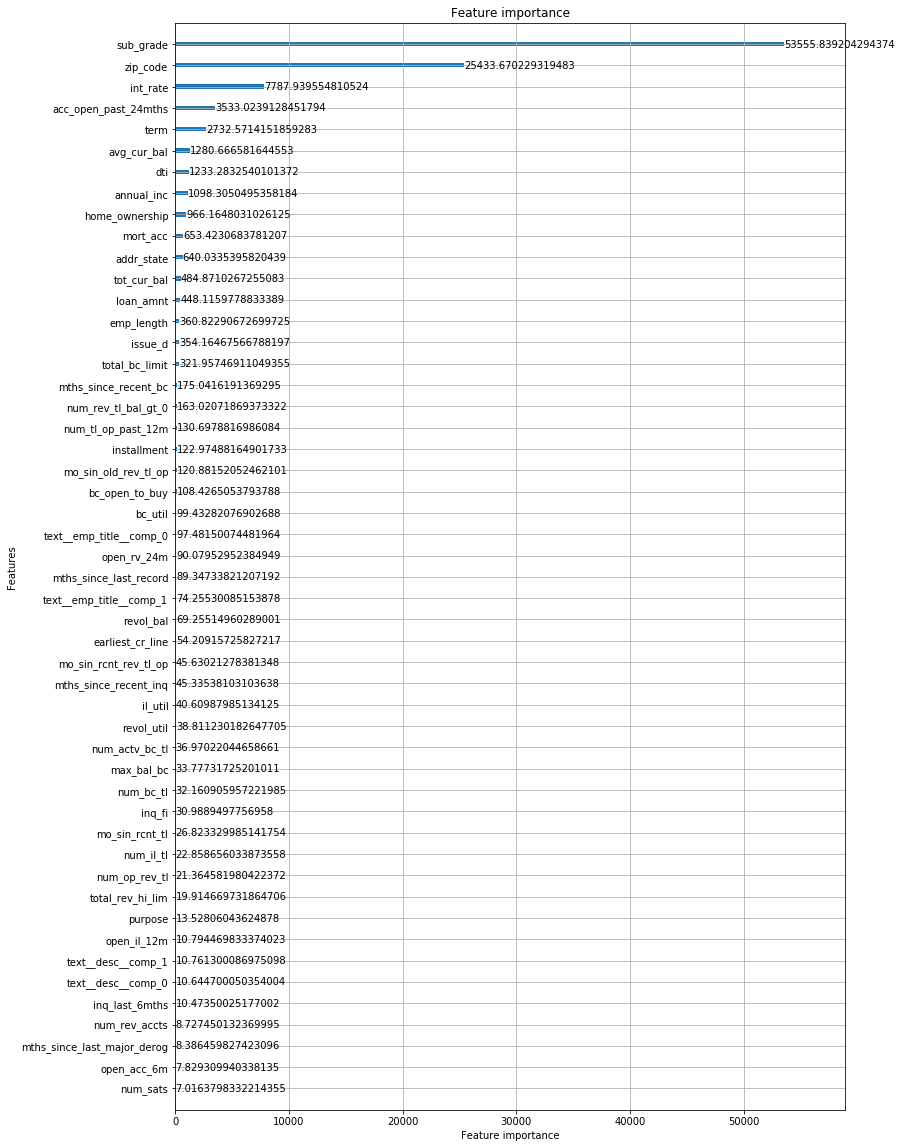

In [42]:
print('Plotting feature importances...')
fig, ax = plt.subplots(figsize=(12,20))

lgb.plot_importance(gbm, max_num_features=50, ax=ax, importance_type = 'gain')
plt.show()

importance_type (string, optional (default="split")) – How the importance is calculated. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

In [43]:
feature_importance = gbm.feature_importance()
feature_name=gbm.feature_name()

In [44]:
feature_importance_DF = pd.DataFrame.from_dict({'feature_name':feature_name,'feature_importance':feature_importance}
                      ).sort_values('feature_importance', ascending=False).reset_index(drop=True)

In [45]:
feature_importance_DF = feature_importance_DF.replace({'feature_name':{'text__emp_title__comp_1': 'emp_title',
'text__emp_title__comp_0': 'exclude',
'text__emp_title__comp_2': 'exclude',
'text__desc__comp_2':'desc',
'text__desc__comp_1':'exclude',
'text__desc__comp_0':'exclude',
'text__title__comp_0':'desc',
'text__title__comp_1':'title',
'text__title__comp_2':'title'}}).query('feature_name ! = "exclude"')


In [46]:
feather.write_dataframe(feature_importance_DF, os.path.join(data_DIR,'variables_primary_selection.feather'))
